In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pylab as plt
from jupyterthemes import jtplot
import numpy as np
import time
from scipy.optimize import curve_fit
import datetime

jtplot.style(theme='onedork')
# plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [2]:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
# url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url, index_col=[0,1]).swaplevel(1,0)
df

,,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
Country/Region,Province/State,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,33.000000,65.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,2
Albania,NaN,41.153300,20.168300,0,0,0,0,0,0,0,0,...,1,1,2,2,2,2,2,4,5,5
Algeria,NaN,28.033900,1.659600,0,0,0,0,0,0,0,0,...,4,4,7,9,11,15,17,17,19,21
Andorra,NaN,42.506300,1.521800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
Angola,NaN,-11.202700,17.873900,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Libya,NaN,26.335100,17.228331,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
West Bank and Gaza,NaN,31.952200,35.233200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
Guinea-Bissau,NaN,11.803700,-15.180400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df = df.drop(['Lat', 'Long'], 1).T

In [4]:
df.index = pd.to_datetime(df.index)

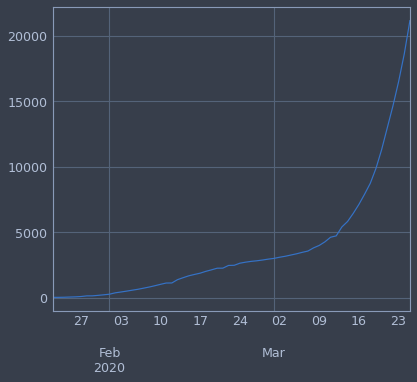

In [5]:
df.T.sum().plot()

In [6]:
len(df.columns)

245

In [7]:
df_exchina = df.drop('China', 1)
df_exchina = df_exchina[df_exchina.T.sum() > 1]
len(df_exchina.columns)

/usr/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


212

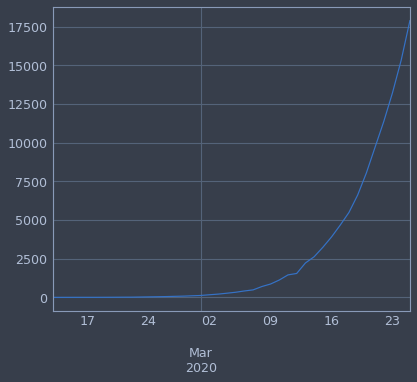

In [8]:
df_exchina.T.sum().plot()

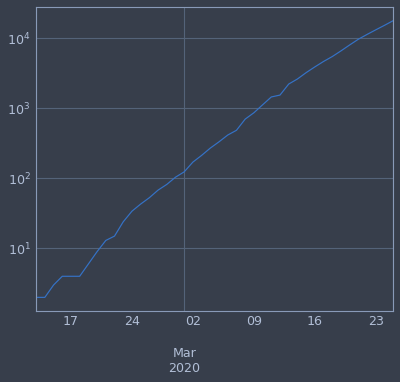

In [9]:
df_exchina.T.sum().plot(logy = True)

In [10]:
def sigmoid(x, sat, td, velo):
    x = np.float64(x)
    
    td *= 1e10
    td *= 1e9
    
    real_sat = 1e5 * sat
    x = x - td
    x /= 1e14
    return real_sat / (1 + np.exp(-x * velo))

x = df_exchina.index
sat = 30000 / 1e5
td = time.time() / 1e10
velo = .1

In [11]:
popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_exchina.index, 
                       ydata = df_exchina.T.sum(), 
                       p0 = (sat, td, velo)
                      )

In [12]:
y_fit = sigmoid(x, *list(popt))

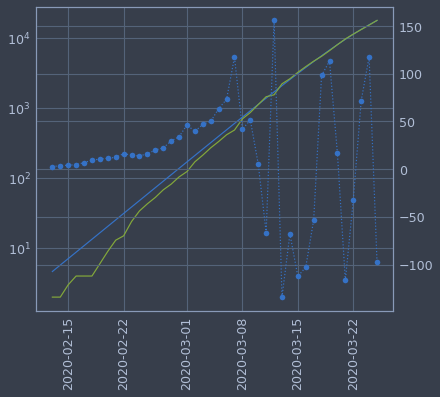

In [13]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)


ax1.semilogy(x, y_fit)
ax1.semilogy(x, df_exchina.T.sum())

ax2 = ax1.twinx()
ax2.plot(x, y_fit - df_exchina.T.sum(), "o:")

In [14]:
th = datetime.datetime.fromtimestamp(popt[1] * 1e10)

In [15]:
f'The total number of Deaths outside China due to Covid-19 will be {int(popt[0] * 1e5)}. Half of those will be reached at {th.strftime("%Y-%B-%d %H:%M")}'

'The total number of Deaths outside China due to Covid-19 will be 49322. Half of those will be reached at 2020-March-27 17:39'

In [16]:
tstart = min(df_exchina.index)
tend = tstart + (th - tstart) * 2

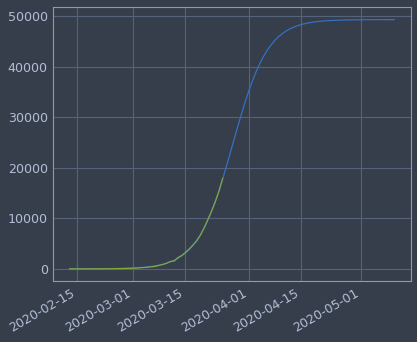

In [17]:
x_extra = np.arange(tstart, tend, datetime.timedelta(days=1)).astype('datetime64[ns]')
y_extra = sigmoid(x_extra, *list(popt))

plt.plot(x_extra, y_extra)
df_exchina.T.sum().plot()
plt.show()

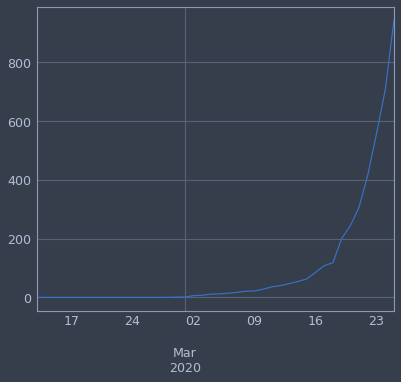

In [18]:
df_exchina["US"].T.sum().plot(logy=False)

In [19]:
df_exchina.T.sum().diff()

2020-02-13       NaN
2020-02-14       0.0
2020-02-15       1.0
2020-02-16       1.0
2020-02-17       0.0
2020-02-18       0.0
2020-02-19       2.0
2020-02-20       3.0
2020-02-21       4.0
2020-02-22       2.0
2020-02-23       9.0
2020-02-24      10.0
2020-02-25       9.0
2020-02-26      10.0
2020-02-27      15.0
2020-02-28      14.0
2020-02-29      22.0
2020-03-01      20.0
2020-03-02      47.0
2020-03-03      42.0
2020-03-04      58.0
2020-03-05      62.0
2020-03-06      83.0
2020-03-07      70.0
2020-03-08     216.0
2020-03-09     163.0
2020-03-10     258.0
2020-03-11     331.0
2020-03-12      94.0
2020-03-13     676.0
2020-03-14     402.0
2020-03-15     611.0
2020-03-16     672.0
2020-03-17     766.0
2020-03-18     817.0
2020-03-19    1126.0
2020-03-20    1428.0
2020-03-21    1668.0
2020-03-22    1663.0
2020-03-23    1854.0
2020-03-24    2113.0
2020-03-25    2551.0
dtype: float64

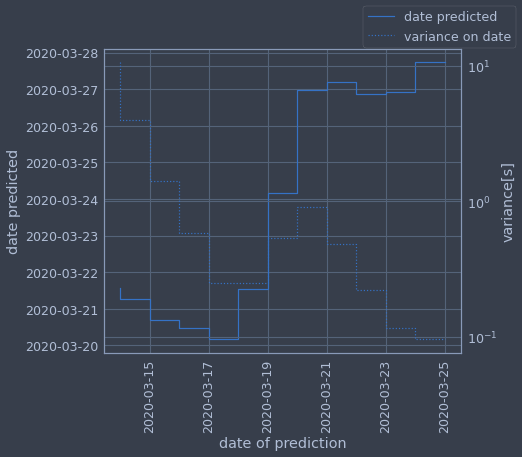

In [20]:
x = []
y_var = []
y = []

for e in df_exchina.index[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    
    x.append(e)
    y_var.append(np.diag(pcov)[1] * 1e10)
    y.append(datetime.datetime.fromtimestamp(popt[1] * 1e10))
    


fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
plt.xlabel("date of prediction")

plt.ylabel("date predicted")

ax1.plot(x, y, label='date predicted', drawstyle='steps')

ax2 = ax1.twinx()
ax2.semilogy(x, y_var, ":", label='variance on date', drawstyle='steps')
plt.ylabel("variance[s]")

fig.legend()